<a href="https://colab.research.google.com/github/RDifault/Computer-Vision/blob/main/Image_Matching_Using_SIFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install versi OpenCV yang support SIFT
!pip uninstall -y opencv-contrib-python
!pip install opencv-contrib-python==3.4.2.17

Found existing installation: opencv-contrib-python 3.4.2.17
Uninstalling opencv-contrib-python-3.4.2.17:
  Successfully uninstalled opencv-contrib-python-3.4.2.17
  Using cached opencv_contrib_python-3.4.2.17-cp37-cp37m-manylinux1_x86_64.whl (30.6 MB)


In [ ]:
# Import library yang akan digunakan
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

1.	Selecting representative images from an image dataset (https://github.com/willard-yuan/image-retrieval/tree/master/bag-of-words-python-dev-version)

In [ ]:
# Load semua gambar yang ada di dataset
image_path = "dataset/"
image = os.listdir(image_path)

images = []
for i in image:
    images.append(cv2.imread(image_path + i))

2.	Collect all the SIFT descriptors from the images in 1)

In [ ]:
# Memanggil SIFT
SIFT = cv2.xfeatures2d.SIFT_create()

In [ ]:
# Mendapatkan semua descriptor gambar dataset
# Kemudian tampung ke array

descriptors = []
for i in images:
  _, img_desc = SIFT.detectAndCompute(i, None)
  descriptors.append(img_desc)

3.	Cluster these descriptors using K Means into k number of clusters where k is a number you set. The center of these clusters are the "visual words" i.e. representative features in your database of images.

In [ ]:
# Import library kmeans
from scipy.cluster.vq import kmeans, vq

In [ ]:
# Reshape descriptor agar dapat digunakan di kmeans
desc = descriptors[0][1]
for i in descriptors[1:]:
    desc = np.vstack((desc, i))

print(desc.shape)

(105500, 128)


In [ ]:
# Melakukan kmeans
k = 400
voc, _ = kmeans(desc, k, 1)

4.	For every image in the database, you are going to create a vector V that counts how frequently the different features in the dictionary occurs

In [ ]:
# Vector V, loop semua centroid di voc u/ hitung frekuensi munculnya
V = np.zeros((len(image), k), "float32")

for i in range(len(image)):
    words, _ = vq(descriptors[i], voc)
    for w in words:
        V[i][w] += 1

5.	At this stage, you might want to normalize the histogram by dividing each entry by the sum of all the entries so that images with very different number of SIFT key-points found can be made comparable.

In [ ]:
# Untuk normalisasi, saya menggunakan normalize dari preprocessing
from sklearn.preprocessing import normalize

In [ ]:
V2 = normalize(V)

6.	Now, to compare 2 images, you compare this new vector V instead of the SIFT descriptors themselves. It is recommended to use cosine similarity to evaluate how close your query image with images in the database.

In [ ]:
# Load image yang akan dicari, kemudian lakukan step yang sama dengan image dataset di atas
search_image = cv2.imread("search.jpg")
_, search_des = SIFT.detectAndCompute(search_image, None)

In [ ]:
search_V = np.zeros((1, k), "float32")
words, _ = vq(search_des, voc)
for w in words:
    search_V[0][w] += 1

In [ ]:
search_V2 = normalize(search_V)

In [ ]:
# Compare image dengan menggunakan vector V
score = np.dot(search_V2, V2.T)
similarity = np.argsort(-score)[0]

In [ ]:
# Import library untuk cosine similarity
from scipy import spatial

In [ ]:
# Hitung nilai similarity, kemudian cari nilai similarity tertinggi
similarity = []

for i in range(len(V2)):
  curr = 1 - spatial.distance.cosine(search_V2, V2[i])
  similarity.append(curr)

result_index = similarity.index(max(similarity))

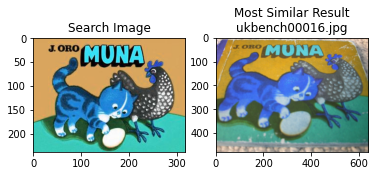

In [ ]:
plt.subplot(1,2,1)
plt.imshow(search_image)
plt.title('Search Image')

plt.subplot(1,2,2)
plt.title("Most Similar Result\n" + image[result_index])
plt.imshow(images[result_index])

plt.show()